# Hands-On Deep Learning modelo MLP para series de tiempo
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%201%20-%20Time%20Series/mlp-time-series.ipynb)

En este notebook vamos a comenzar a usar redes para casos de series de tiempo. Vamos a empezar con una red sencilla tipo MLP (Multi-Layer Perceptron) que no es mas que unas cuantas capas densas en fila. También lo vamos a comparar con un modelo clásico para empezar a ver las diferencias entre estos.

A partir de aquí, vamos a trabajar con datasets reales para poder poner en práctica los conceptos vistos hasta el momento. Además de ello, en este notebook vamos a trabajar de una forma un poco más realista el proceso de entrenamiento. Es decir, vamos a crear y preparar los conjuntos de entrenamiento y validación, además de calcular las métricas de comparación entre los modelos. Este notebook será de buena guía para los entregables del resto del curso.

## Serie de tiempo del clima del laboratorio Max Planck
Para este notebook vamos a trabajar sobre una serie de datos climáticos cuyo dataset pueden encontrar aquí: https://www.kaggle.com/datasets/arashnic/max-planck-weather-dataset/data. Debido a que el dataset son 42MB y requiere autenticación en kaggle para descargar, esto deberán hacerlo manualmente antes de continuar con el notebook.

El objetivo de este caso es modelar la serie de tiempo de la temperatura atmosférica en grados centigrados. Para ello, contamos no solo con datos desde el 2009 al 2016 sobre la temperatura misma sino de otras mediciones como la presión atmosférica, presión de vapor, humedad, entre otros. Los datos fueron tomados especificamente en la estación del clima Beuternberg

### Enlaces de interés
- [Max-Planck Institut](https://mpimet.mpg.de/en/research/observations)
- [Max-Planck Institut - Weather Station](https://www.bgc-jena.mpg.de/wetter/)
- [Weather Station Beutenberg](https://www.bgc-jena.mpg.de/wetter/towercam.html)
- [Beutenberg Campus](https://maps.app.goo.gl/fGJX1T9bjTJhueqJ9)

In [1]:
import pkg_resources
import warnings
import os

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

datasets_path = './datasets/' if IN_COLAB else '../datasets'
# Para guardar modelos entrenados y re-utilizarlos luego
models_path = os.path.join(os.getcwd(), 'models')
os.makedirs(models_path, exist_ok=True)

In [2]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/requirements.txt  && pip install -r requirements.txt

In [3]:
!test '{IN_COLAB}' = 'True' && wget https://tinyurl.com/2swakt92 -O mlp-ts.zip && unzip mlp-ts.zip
!test '{IN_COLAB}' = 'True' && wget https://tinyurl.com/3aamktz3 -O datasets.zip && unzip datasets.zip
!test '{IN_COLAB}' = 'True' && wget https://tinyurl.com/39t3duhu -O sarimax.zip && unzip sarimax.zip

Primero, vamos a observar los datos y hacernos una idea de con que estamos lidiando.

In [4]:
import pandas as pd
import numpy as np

# El dataset cuenta con temperatura en grados Kelvin también
# Pero no queremos incluir esta columna porque está midiendo exactamente lo mismo
columns = ['T (degC)', 'p (mbar)', 'VPact (mbar)', 'sh (g/kg)', 'Tdew (degC)', 'H2OC (mmol/mol)']
# Cambiar según la localización del archivo.
dataset = pd.read_csv(os.path.join(datasets_path, 'max_planck_weather_ts.csv'))[columns]

dataset.head(15)

,T (degC),p (mbar),VPact (mbar),sh (g/kg),Tdew (degC),H2OC (mmol/mol)
0,-8.02,996.52,3.11,1.94,-8.90,3.12
1,-8.41,996.57,3.02,1.89,-9.28,3.03
2,-8.51,996.53,3.01,1.88,-9.31,3.02
3,-8.31,996.51,3.07,1.92,-9.07,3.08
4,-8.27,996.51,3.08,1.92,-9.04,3.09
5,-8.05,996.50,3.14,1.96,-8.78,3.15
6,-7.62,996.50,3.26,2.04,-8.30,3.27
7,-7.62,996.50,3.25,2.03,-8.36,3.26
8,-7.91,996.50,3.15,1.97,-8.73,3.16
9,-8.43,996.53,3.00,1.88,-9.34,3.02


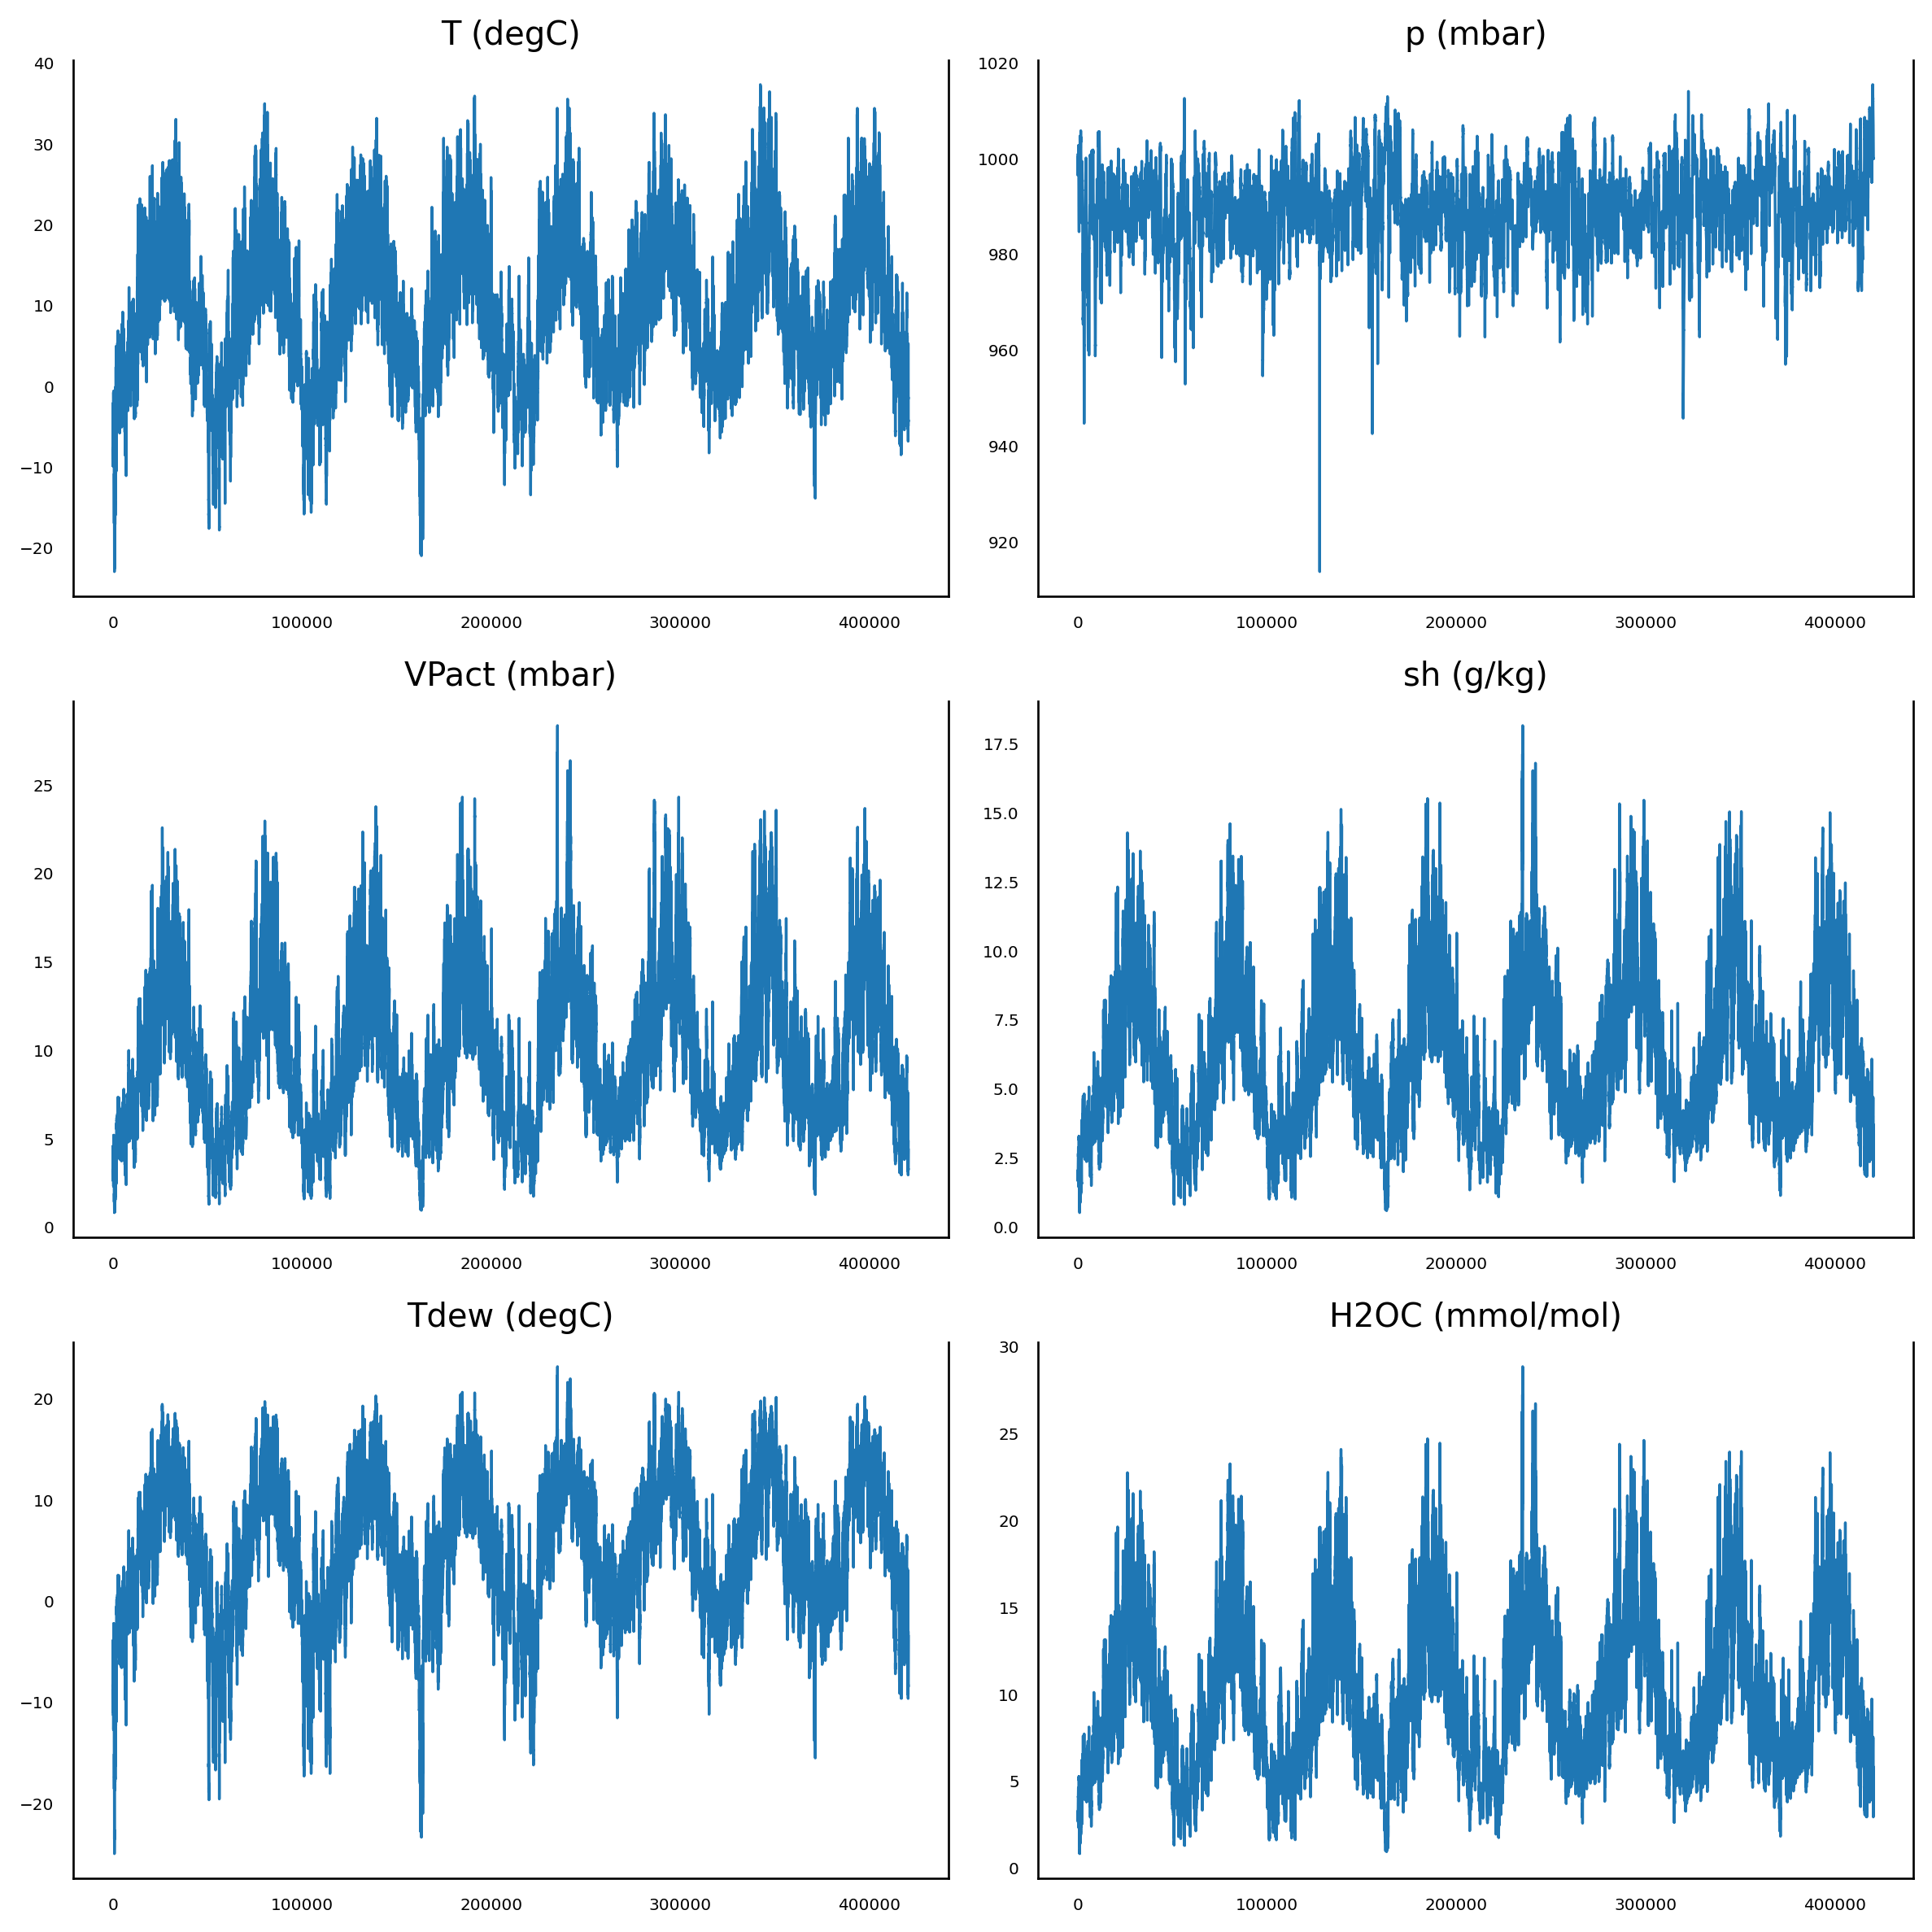

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=240, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    data = dataset[dataset.columns[i]]
    
    ax.plot(data, linewidth=1)
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

## Train-test split
Como este es un experimento un poco más realista, vamos a separar los conjuntos de datos en train y test. Como ya debemos saber, el conjunto de entrenamiento es exclusivamente para ese fin y el conjunto de prueba únicamente debemos usarlo para validar el modelo ante información no vista durante el entrenamiento y así poner a prueba su capacidad predictiva.

Como esto es una serie de tiempo, no podemos hacer un random sample ya que romperíamos la estructura secuencial de los datos. Asi que vamos a hacer algo más simple y dividir el conjunto en un punto particular. Vamos a trabajar con un train set correspondiente al 90% del conjunto original.

In [6]:
train_chunk = int(dataset.shape[0] * 0.9)

# Solo nos interesa trabajar con estas columnas por ahora
columns = ['T (degC)', 'p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)']

# Necesitamos trabajar solo con datos informados, por lo que debemos descartar registros que no los tengan
train_set = dataset.iloc[:train_chunk][columns].dropna()
test_set = dataset.iloc[train_chunk:][columns].dropna()


## Baseline - Modelo SARIMAX
Para tener un modelo base de referencia, vamos a entrenar un modelo SARIMAX como ya hemos estado practicando. Se omiten todos los pasos de comprobación anteriormente vistos y se entrena directamente un modelo con una estimación óptima de ordenes.

#### Nota
Algo para tener en cuenta, es que el conjunto de entrenamiento cuenta con mas de 300K ejemplares. Ya que vamos a entrenar un modelo SARIMAX completo (diferenciación y ordenes completos para los componentes regulares y estacionales) y además de eso, cada paso de tiempo es un vector de 4 dimensiones, la cantidad de datos posibles a manejar en una sola máquina con un procedimiento convencional puede ser impráctica. Nos vemos entonces forzados a reducir la cantidad de datos que utilizamos para entrenar el modelo. Esto puede ser tan bueno como malo, según corresponda y los resultados obtenidos.

In [7]:
%%time
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model_path = os.path.join(models_path, 'sarimax_model.pkl')
relative_path = os.path.relpath(sarimax_model_path, os.getcwd())
if os.path.exists(sarimax_model_path):
    with open(sarimax_model_path, 'rb') as f:
        sarimax_model = pickle.load(f)
    
    print(f'Usando un modelo pre-entrenado en {relative_path}')
else:
    # Trabajaremos con los últimos 200k pasos de tiempo solamente.
    endog = train_set.loc[len(train_set)-200000:, 'T (degC)']
    exog = train_set.loc[len(train_set)-200000:, ['p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)']].values

    sarimax = SARIMAX(endog, exog, order=(1, 1, 2), seasonal_order=(1, 1, 2, 4), simple_differencing=False)
    sarimax_model = sarimax.fit(disp=False)
    
    sarimax_model.save(sarimax_model_path)

    print(f'Guardando modelo en {relative_path}')

print(sarimax_model.summary())

Usando un modelo pre-entrenado en models/sarimax_model.pkl
                                     SARIMAX Results                                     
Dep. Variable:                          T (degC)   No. Observations:               200000
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 4)   Log Likelihood               46387.378
Date:                           Sun, 03 Mar 2024   AIC                         -92754.757
Time:                                   15:42:22   BIC                         -92652.696
Sample:                                        0   HQIC                        -92724.718
                                        - 200000                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2265      0.002   -115.573      0.000      -0.

Hemos entrenado el modelo SARIMAX en el que todos sus coeficientes son estadísticamente significativos. Procedamos a calcular el MSE para tenerlo como referencia al momento de entrenar el modelo MLP luego.

In [8]:
from sklearn.metrics import mean_squared_error

test_endog = test_set['T (degC)']
test_exog = test_set[['p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)']]

sarimax_preds = sarimax_model.get_forecast(steps=test_endog.shape[0], exog=test_exog).predicted_mean

validation = pd.DataFrame({'data': test_endog.values, 'prediction': sarimax_preds.values})

mse = mean_squared_error(validation['data'], validation['prediction'])
print(f"MSE Modelo SARIMAX: {mse:.4f}")
# Ya no necesitamos mas el modelo sarimax en memoria
del sarimax_model

MSE Modelo SARIMAX: 75.0673


## Modelo MLP simple

![](../assets/TS-SimpleMLP.drawio-wbg.png)
Ahora vamos a entrenar un modelo MLP simple para el mismo problema. Sin embargo, debemos hacer unos preparativos antes ya que la forma en que estos modelos se entrenan requieren que los datos sean suministrados de una forma diferente. 

Recordemos que las redes neuronales se entrenan con muestras y en baches, a diferencia del modelo clásico que puede recibir el conjunto de datos entero.

Lo que necesitamos es construir un *pytorch dataset* que entregue pares $x$, $y$ de los ejemplares de entrenamiento. Pero, y qué es $x$ y $y$? La **analogía** con el modelo SARIMAX, es que definimos un orden auto-regresivo de $p$ lags; entonces en el caso de la red neuronal, nuestro $x$ vendría siendo una secuencia de $p$ pasos de tiempo, y el valor $y$ será el dato que le sigue, el objetivo.

#### Nota
Lo anterior es una simple analogía y no debe tomarse como una comparación 1:1. Recordemos que los ordenes se definen en función de su correlación con el paso de tiempo en particular, en una red neuronal, para el análisis de secuencias, la entrada debe ser la secuencia misma, independientemente de la tarea final (clasificación, regresión, encoding, etc.). La longitud de la secuencia es un hiper-parámetro que podemos controlar según vamos experimentando.

In [9]:
%%time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from pytorch_lightning import LightningModule, Trainer
from typing import List, Tuple
from torch.nn import functional as F
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split


class TimeSeriesDataset(Dataset):
    """Time Series Dataset.
    Define un pytorch dataset desde un pandas dataframe.
    Asume que el dataframe provisto es una serie donde
    cada fila corresponde a un paso de tiempo t y cada
    columna son el vector a procesar.
    """
    def __init__(self, 
                 dataframe: pd.DataFrame,
                 target_col: str,
                 feature_cols:  List[str],
                 sequence_length: int = 10) -> None:
        super().__init__()
        self._dataframe = dataframe.reset_index(drop=True)
        self.sequence_length = sequence_length
        self.target_col = target_col
        self.feature_cols = feature_cols
        self.scaler = StandardScaler()
        self.cache = {}

    
    def __len__(self):
        # Porque a partir de n - sequence length, no se podrán extraer más secuencias.
        return len(self._dataframe) - self.sequence_length
    
    def __getitem__(self, index) -> Tuple[torch.Tensor]:
        if index in self.cache:
            return self.cache[index]

        start_idx = index
        end_idx = index + self.sequence_length - 1

        # Extraemos las secuencias, el valor objetivo debe estar incluido en la secuencia.
        sequence = self._dataframe.loc[start_idx:end_idx, [self.target_col] + self.feature_cols].values
        # Aplicamos escala si es necesario
        sequence = self.scaler.fit_transform(sequence)
        
        # Extraemos el objetivo
        target = self._dataframe.loc[end_idx, self.target_col]

        # Convertimos a tensores de pytorch
        sequence = torch.tensor(sequence, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        self.cache[index] = (sequence, target)

        return sequence, target


sequence_length = 200
train_dataset = TimeSeriesDataset(
    train_set[columns], 
    target_col='T (degC)', 
    feature_cols=['p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)'],
    sequence_length = sequence_length
    )

# Este split puede tomar ~15min
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, train_size=0.8)

# Creamos los dataloaders para el entrenamiento de la red
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=6)

CPU times: user 18min 59s, sys: 4.11 s, total: 19min 3s
Wall time: 19min 10s


### Definición del modelo y entrenamiento

Ahora, podemos proceder a definir el modelo y entrenarlo.

Nuestro modelo es una arquitectura simple de capas densas y sus activaciones. Técnicamente no deberíamos necesitar más porque los datos en si no son complejos (son simplemente escalares).

In [10]:
%%time
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

class SimpleMLP(LightningModule):

    def __init__(self, input_size, output_size):
        super(SimpleMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
        self.hparams['network'] = str(self.network)
        self.save_hyperparameters()

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y.unsqueeze(-1))
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y.unsqueeze(-1))
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y.unsqueeze(-1))
        self.log('test_loss', loss)

    def predict_step(self, batch):
        x, y = batch
        return torch.cat([self(x), y.unsqueeze(-1)], axis=-1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Cada time step tiene 4 dimensiones (temperatura*, presión, punto de rocío, concentración de vapor de agua)
# * es a su vez el valor objetivo, pero en el siguiente paso de tiempo
# El input shape para la red es entonces (batch_size, sequence_length, 4)
# La capa densa espera un vector de shape (batch_size, sequence_length * 4), estamos haciendo flatten
mlp_model = SimpleMLP(sequence_length * 4, 1)

tb_logger = TensorBoardLogger('tb_logs', name='SimpleMLP')
trainer = Trainer(max_epochs=10, devices=1, logger=tb_logger, callbacks=[EarlyStopping(monitor='val_loss', mode='min')])
trainer.fit(mlp_model, train_loader, val_loader)
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 110 K 
---------------------------------------
110 K     Trainable params
0         Non-trainable params
110 K     Total params
0.443     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 296/296 [00:04<00:00, 61.60it/s, v_num=2, train_loss=21.20]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 296/296 [00:04<00:00, 61.42it/s, v_num=2, train_loss=21.20]
CPU times: user 33.8 s, sys: 14 s, total: 47.8 s
Wall time: 50.6 s


Hemos entrenado el modelo, ahora exploremos su curva de aprendizaje con tensorboard:

In [11]:
%load_ext tensorboard

In [12]:
%tensorboard --logdir tb_logs/

Reusing TensorBoard on port 6006 (pid 289111), started 3 days, 7:31:51 ago. (Use '!kill 289111' to kill it.)

No luce mal, parece que el modelo aprende relativamente rápido. Exploremos como se comporta el modelo en el test set:

In [13]:
mlp_model.eval()
test_dataset = TimeSeriesDataset(
    test_set[columns], 
    target_col='T (degC)', 
    feature_cols=['p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)'],
    sequence_length = sequence_length
    )
test_loader = DataLoader(test_dataset, batch_size=512)
result = trainer.test(dataloaders=test_loader)

Restoring states from the checkpoint path at tb_logs/SimpleMLP/version_2/checkpoints/epoch=9-step=2960.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at tb_logs/SimpleMLP/version_2/checkpoints/epoch=9-step=2960.ckpt


Testing DataLoader 0: 100%|██████████| 82/82 [00:42<00:00,  1.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           30.882305145263672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Resultados intresantes
Hemos obtenido una pérdida MSE más pequeña que con el modelo SARIMAX. Esto en principio parece bien, nos indicaría que el modelo es mejor que el clásico. Pero no cantemos victoria tan pronto. Exploremos las predicciones de ambos visualmente y miremos que tan buenos son.

| Modelo | MSE Loss |
|--------|----------|
| SARIMAX| 75.0673  |
| MLP    | 30.8823  |

## Pronósticos
Ahora observemos como se comportan estos modelos haciendo pronósticos sobre el conjunto de prueba.

In [14]:
mlp_batched_preds = trainer.predict(dataloaders=test_loader)
mlp_preds = np.concatenate([b.numpy() for b in mlp_batched_preds])

Restoring states from the checkpoint path at tb_logs/SimpleMLP/version_2/checkpoints/epoch=9-step=2960.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at tb_logs/SimpleMLP/version_2/checkpoints/epoch=9-step=2960.ckpt


Predicting DataLoader 0: 100%|██████████| 82/82 [00:00<00:00, 199.61it/s]


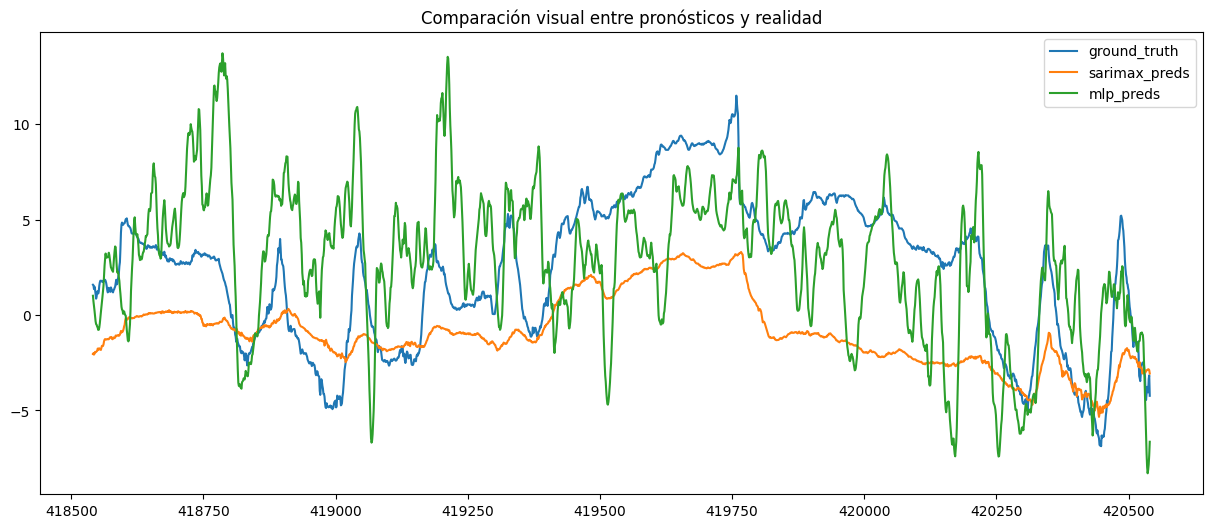

In [15]:
steps = 2000
visual_check = pd.DataFrame({
    'ground_truth': mlp_preds[-steps:, 1],
    'sarimax_preds': sarimax_preds[-steps-10:][:-10],
    'mlp_preds': mlp_preds[-steps:, 0]    
})

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
visual_check.plot.line(ax=ax)
plt.title("Comparación visual entre pronósticos y realidad")
plt.show()

Pues vaya! a simple vista pareciese que el modelo SARIMAX ofrece predicciones más realistas! El modelo MLP se comporta mucho más errático aunque pareciese que intenta seguir su tendencia.

Quizás sea posible hacer mejoras al modelo MLP, como por ejemplo añadir regularización tanto en la red (dropout, batch normalization) como en la función de pérdida, en lugar de calcular un simple MSE en el entrenamiento, añadir una penalización adicional.

De todos modos es importante tener en cuenta que el modelo MLP simple recibe la secuencia como un vector donde nunca explora las relaciones espacio-temporales entre las dimensiones, entonces en cierto modo funciona como una *regresión lineal múltiple*, donde simplemente recibe todos los features y los opera de forma lineal. En la lección siguiente exploraremos otras capas que si harán uso de estas relaciones y compararemos los resultados con esta.

## Conclusiones
- Las métricas como el MSE son una forma de comparar modelos entre si, sobretodo cuando la naturaleza de los mismos es tan diferente.
- A pesar de obtener métricas aparentemente mejores, siempre es bueno realizar comprobaciones visuales para ver si realmente el modelo está dando resultados o no.
- El análisis de error puede ser útil aquí para ver que modificaciones debemos hacer en la red para obtener mejores resultados.